# Convolutional Kitchen Sinks

When trying out a fancy new deep learning model, it's important to compare to a more naive baseline. My favorite baseline, for which Ali Rahimi and Ben Recht have been the loudest champions, is **random kitchen sinks**. The basic idea is to replace minimization (learning features) with randomization (creating a lot of features and selecting the best ones).

As Ali said on [hackernews](https://news.ycombinator.com/item?id=6730800):

"(On a serious note: MNIST is considered a trivial dataset and doesn't require the heavy machinery of deep nets. linear regression on almost any random nonlinearity applied to the data (say f(x;w,t)=cos(w'x+t) with w~N(0,I) and t~U[0,pi2/]) will get you >98% accuracy on MNIST.)
-- rahimiali

More explicitly, you can

1. Rescale features to zero mean and unit variance.
2. Project to a lower-dimensional space using PCA.
3. Construct random features by applying some nonlinear function (sign, ReLU, cosine, tanh)
4. Fit a linear (logistic) model.

In this note, we will implement that approach on some classic datasets: MNIST, Fashion-MNIST (which has richer classes), and CIFAR-10.

We will also attempt to generalize it to spatially structed datasets like images, and see how much that helps. Call them Random Convolutional Sinks.

## The model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
from sklearn import linear_model
from sklearn.metrics import confusion_matrix

%matplotlib inline 

In [2]:
def median_dist(X):
    """Compute the approximate median distance by sampling pairs."""
    k = 1<<20  # 1M random points
    i = np.random.randint(0, X.shape[0], k)
    j = np.random.randint(0, X.shape[0], k)
    return np.sqrt(np.median(np.sum((X[i,:] - X[j,:])**2, axis=1)))

def pca(X, dim):
    """Perform centered PCA."""
    X = X - X.mean(axis=0)
    return LA.eigh(X.T.dot(X))[1][:,-dim:]

In [3]:
class KitchenSinks():
    def __init__(self, nonlinearity = 'cosine', latent_dim = 50, n_features = 1000):
        self.nonlinearity = nonlinearity
        self.latent_dim = latent_dim
        self.n_features = n_features
    
        self.W = None
        self.logit = None
    
    def fit(self, X, y):
        np.random.seed(0)
        # we are just gonna work with a low-dimensional projection, 50 effective pixels instead of 784
        V = pca(X, self.latent_dim)
        Xproj = X.dot(V)
        sigma = median_dist(Xproj)
        
        W = np.random.randn(self.latent_dim, self.n_features)/sigma
        b = np.random.uniform(-np.pi, np.pi, self.n_features)
        
        X_red = np.cos(Xproj.dot(W) + b)
 
        logit = linear_model.LogisticRegression()
        logit.fit(X_red, y)

        self.logit = logit
        self.W = W
        self.b = b
        self.V = V
        
    def predict(self, X):
        X_red = np.cos(X.dot(self.V).dot(self.W) + self.b)
        return self.logit.predict(X_red)
    
    def score(self, X, y):
        X_red = np.cos(X.dot(self.V).dot(self.W) + self.b)
        return self.logit.score(X_red, y)

In [4]:
x = np.random.randn(1000,10)
w = np.random.randn(10)
y = np.sign(np.tan(x.dot(w)))
ks = KitchenSinks(n_features = 200, latent_dim = 10)
ks.fit(x, y)
ks.score(x, y)

0.644

# Fashion MNIST

[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist#loading-data-with-other-machine-learning-libraries) is a dataset with the same size as MNIST but somewhat more difficult objects: articles of clothing instead of numbers.

It is somewhat less trivial because, for example, shape matters independent of intensity. So a silhoutte may define a shirt, but a white shirt and a black shirt are very far apart in pixel-space.

In [6]:
# We use keras to download datasets
import keras

Using TensorFlow backend.


In [7]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

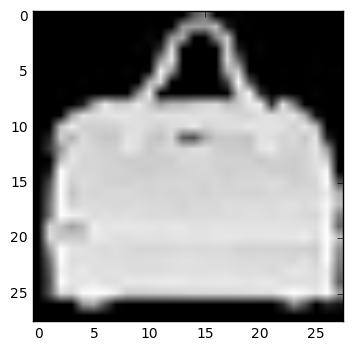

In [12]:
plt.imshow(x_train[220], cmap=plt.cm.gray)

In [13]:
id_string =  """0	T-shirt/top
                1	Trouser
                2	Pullover
                3	Dress
                4	Coat
                5	Sandal
                6	Shirt
                7	Sneaker
                8	Bag
                9	Ankle boot"""
ids = [x.split()[1] for x in id_string.split("\n")]

In [14]:
# Reshape to 1-D feature vector
x_train_long = x_train.reshape(x_train.shape[0],-1)
x_test_long = x_test.reshape(x_test.shape[0],-1)

In [15]:
ks = KitchenSinks(n_features = 1000, latent_dim = 50)
ks.fit(x_train_long, y_train)
ks.score(x_train_long, y_train)

0.9064166666666666

Test set accuracy is 88% with 1000 features.

In [19]:
ks.score(x_test_long, y_test)

0.8788

In [20]:
y_pred = ks.predict(x_test_long)
confusion_matrix(y_pred, y_test)

array([[846,   2,  19,  22,   1,   0, 139,   0,   4,   1],
       [  1, 969,   0,   6,   0,   0,   1,   0,   0,   0],
       [ 15,   1, 783,   7,  92,   0,  92,   0,   4,   0],
       [ 23,  21,  12, 890,  30,   1,  28,   0,   7,   0],
       [  5,   4, 103,  31, 811,   0,  71,   0,   1,   0],
       [  3,   0,   0,   1,   0, 948,   0,  22,   3,   7],
       [ 97,   1,  81,  36,  65,   0, 659,   0,   6,   0],
       [  0,   0,   0,   1,   0,  29,   0, 949,   4,  29],
       [ 10,   2,   2,   6,   1,   1,  10,   0, 970,   0],
       [  0,   0,   0,   0,   0,  21,   0,  29,   1, 963]])

In [48]:
def get_eg(x, examples):
    if np.sum(examples) == 0:
        return np.zeros(x[0].shape, dtype = x.dtype)
    else:
        return x[np.argmax(examples)]

In [49]:
im_grid = [[get_eg(x_test, (y_pred == i) & (y_test == j)) for j in range(10)]
            for i in range(10)]
big_im = np.vstack([np.hstack(im_grid[i]) for i in range(10)])

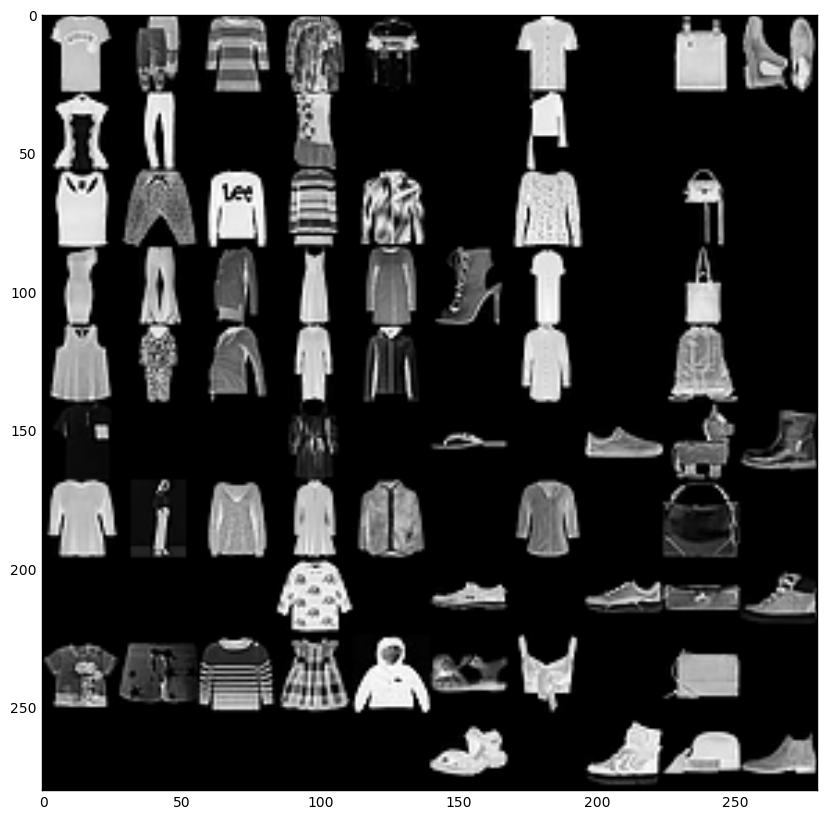

In [60]:
plt.figure(figsize=(10, 10))
plt.imshow(big_im,  cmap=plt.cm.gray)

In [61]:
print(ids)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle']


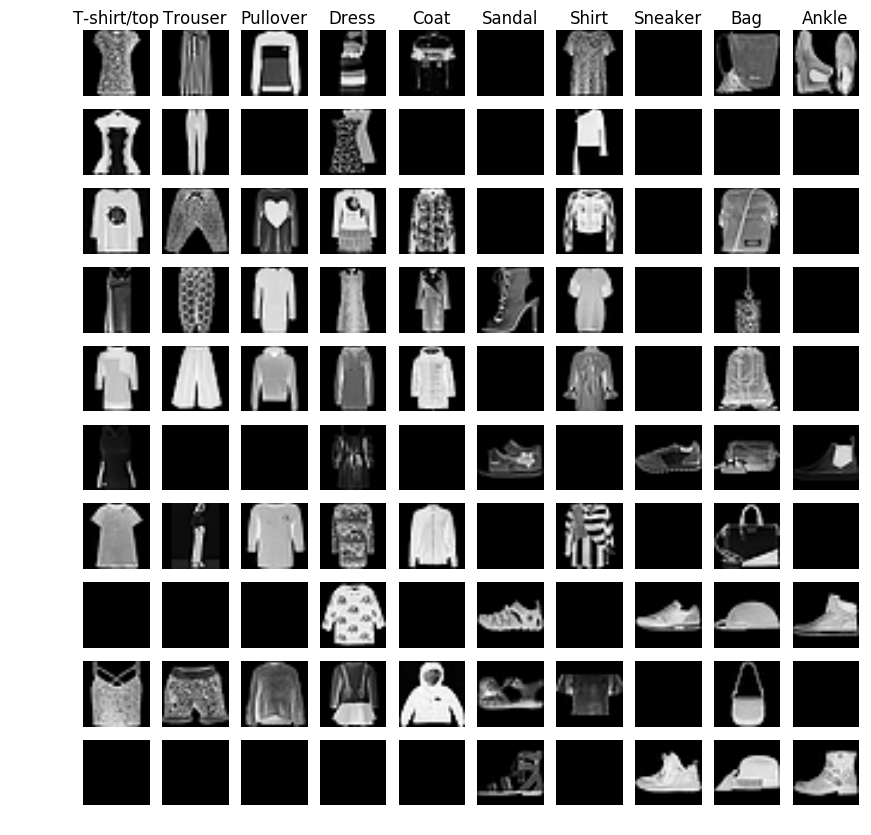

In [75]:
fig, axes = plt.subplots(10,10,figsize=(10,10))
for i in range(10):
    for j in range(10):
        confusions = np.nonzero((y_pred == i) & (y_test == j))[0]
        im = np.zeros(x_test[0].shape, dtype = x_test.dtype)
        if len(confusions) > 0:
            im = x_test[max(confusions)]
        axes[i][j].set_axis_off()
        axes[i][j].imshow(im, cmap = plt.cm.gray)
        
for ax, col in zip(axes[0], ids):
    ax.set_title(col)

for ax, row in zip(axes[:,0], ids):
    ax.set_ylabel(row, rotation=0, size='large')

In [79]:
y_pred = ks2.predict(x_train_long)
confusion_matrix(y_pred, y_train)

array([[5292,    7,   49,  111,    8,    0,  715,    0,   11,    0],
       [   6, 5891,    1,   18,    6,    0,    8,    0,    2,    0],
       [  64,    7, 5048,   35,  365,    0,  454,    0,   17,    1],
       [ 144,   82,   56, 5549,  159,    2,  137,    0,   18,    0],
       [  15,    4,  456,  170, 5107,    0,  365,    0,   15,    0],
       [   5,    0,    0,    2,    1, 5798,    0,   99,    8,   31],
       [ 436,    9,  376,  105,  342,    1, 4278,    0,   30,    0],
       [   1,    0,    0,    0,    0,  158,    0, 5741,   12,  168],
       [  36,    0,   14,   10,   12,    9,   42,    7, 5883,    2],
       [   1,    0,    0,    0,    0,   32,    1,  153,    4, 5798]])

In [76]:
# Save the model
import pickle
with open('kitchen_sink_fashion_mnist.p','wb') as f:
    pickle.dump(ks, f)

In [77]:
with open('kitchen_sink_fashion_mnist.p','rb') as f:
    ks2 = pickle.load(f)

## CIFAR-10

In [ ]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

 42672128/170498071 [======>.......................] - ETA: 17:42

In [ ]:
# Reshape to 1-D feature vector
x_train_long = x_train.reshape(x_train.shape[0],-1)
x_test_long = x_test.reshape(x_test.shape[0],-1)

In [ ]:
ks = KitchenSinks(n_features = 1000, latent_dim = 50)
ks.fit(x_train_long, y_train)
ks.score(x_train_long, y_train)

In [ ]:
ks.score(x_test_long, y_test)

In [ ]:
confusion_matrix(ks.predict(x_test_long), y_test)

## Convolutional Net

## Excess text


In Ali's words, "you've actually probably done this yourself. it's often called "featurization". for example, instead of applying a linear learner on vectors x in R^d, you apply it to vectors f(x), where f computes a bunch of features on x. a popular choice for f are the d-th order monomials. hashing families are another good idea (Alex Smola does this). more generally, any random nonlinear function f is a good candidate (i call that analysis "Random Kitchen Sinks"). when x is structured data, f usually just returns counts in histogram bins of some kind."


Here are a few more of the options for features.


1. Random feature is sign(x<sub>d</sub> - t) where d is drawn at random from feature set (ie coordinate) and t is N(0,1).

2. cos(Wx + b) where entries of W are mean zero, standard deviation sigma, where sigma is the approximate median (L2) distance between the points, and b is a random phase shift (uniform on [0,2 Pi]). This is done here (using 4000 features, and a solver called epsilon): http://epopt.io/en/latest/notebooks/mnist.html The loss function is 'multiclass hinge loss' (learn one linear regression per class: penalty if correct class isn't at least 1 bigger than next best; the penalty is the error plus 1.)

3. Instead of using a random projection to reduce rank, pick target rank, and for each coordinate j pick a target coordinate k at random and a sign at random. Add ±x<sub>j</sub> to x'<sub>k</sub>. This preserves sparsity. If you use a hash function instead of an actual random one, you don't have to store the projection matrix either. Langford (vowpal wabbit) uses these hashed representations built-in. In the paper below, they also use a mixture of global and personalized weights for eg email spam detection.
http://www.machinelearning.org/archive/icml2009/papers/407.pdf